In [51]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import TAPDataset, TAPDataLoader

data_dir = Path("../data/wqp")
# basin_list_file = data_dir / "metadata" / "site_lists" / "sites_all.txt"
basin_list_file = data_dir / "metadata" / "site_lists" / "sites_turb_area1000_n10.txt"

with open(basin_list_file, 'r') as file:
    basin_list = file.readlines()
    basin_list = [basin.strip() for basin in basin_list]

# basin_list = np.random.choice(basin_list,100)

data_args = {'data_dir': data_dir,
             'basin_list': basin_list,
             'features_dict': {'daily':['grfr_q'],
                               'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']},
             'static_features':['wet_pc_s02', 'glc_pc_s11', 'dor_pc_pva', 'soc_th_sav', 'snw_pc_s08', 
                                'wet_pc_s09', 'fmh_cl_smj', 'glc_pc_s14', 'pnv_pc_s11', 'pac_pc_sse'],
             'target': 'turbidity',
             'time_slice': slice('1979-01-01', '2018-12-31'),
             'split_time': np.datetime64('2010-01-01'),
             'sequence_length': 30,
             'log_norm_cols': ['turbidity', 'grfr_q'],
             'clip_target_to_zero': True}

dataset = TAPDataset(**data_args)

Loading Basins:   0%|          | 0/556 [00:00<?, ?it/s]

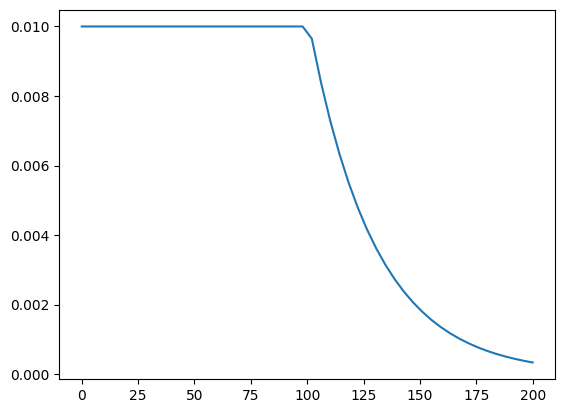

In [58]:
lr_schedule = optax.exponential_decay(0.01, trainer.epoch+num_epochs, 0.001, transition_begin=trainer.epoch)
x = np.linspace(0,num_epochs*2)
y = lr_schedule(x)
plt.plot(x,y)

Output()

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Training finished or interrupted. Model state saved.


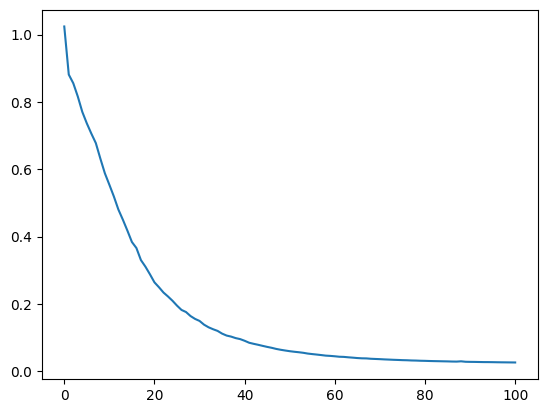

In [54]:
importlib.reload(models)
importlib.reload(train)
from models import TAPLSTM, EALSTM, LSTM
from train import Trainer

loader_args = {'shuffle': True,
               'batch_size': 16,
               'data_subset': 'pre-train',
               'num_workers': 1,
               'pin_memory': True} 
dataloader = TAPDataLoader(dataset, **loader_args)


model_args = {'daily_in_size': len(data_args['features_dict']['daily']),
              'irregular_in_size': len(data_args['features_dict']['irregular']),
              'static_in_size': dataset.x_s[basin_list[0]].shape[0],
              'out_size': 1,
              'hidden_size': 64,
              'dropout': 0.4,
              'seed': 0}

num_epochs = 100
lr_schedule = optax.exponential_decay(0.01, num_epochs, 0.01)
trainer_args = {'model_func': TAPLSTM,
                'model_args': model_args,
                'dataloader': dataloader,
                'lr_schedule': lr_schedule,
                'num_epochs': num_epochs,
                'max_grad_norm': 2}

trainer = Trainer(**trainer_args)
trainer.start_training()

In [ ]:
more_epochs = 150

trainer.load_state('epoch100')
loader_args['data_subset'] = 'train'
trainer.dataloader = TAPDataLoader(dataset, **loader_args)
trainer.lr_schedule = optax.exponential_decay(0.01, trainer.epoch+more_epochs, 0.001, transition_begin=trainer.epoch)
trainer.num_epochs += more_epochs
trainer.freeze_components('tealstm_i',True)
trainer.start_training() 

Output()

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


In [ ]:
from metrics import get_all_metrics

importlib.reload(evaluate)
from evaluate import predict

basin = np.random.choice(basin_list).tolist()

loader_args['data_subset'] = 'test'
loader_args['basin_subset'] =  basin
loader_args['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(dataset, **loader_args)

results = predict(trainer.model, dataloader, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])
metrics

In [ ]:
results

In [ ]:
# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='.')

metrics = get_all_metrics(results['obs'],results['pred'])

plt.title(f"Basin: {basin}, KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.ylim([0,500])
plt.show()

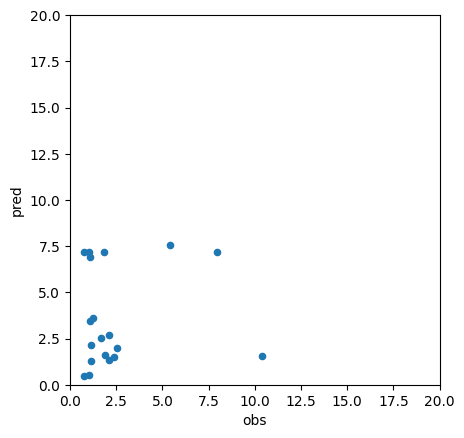

In [40]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

In [109]:
from train import make_step

# See if we can recreate the error... 
data = trainer.load_state("exceptions/epoch130_exception0")
for i in tqdm(range(1000)):
    make_step(trainer.model, data['batch'], trainer.opt_state, trainer.optim,
              trainer.filter_spec, loss_name="mse", max_grad_norm=None, l2_weight=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

False